# Mantid neutron data reduction demo

Welcome to the mantid neutron data demo! Please see the repo `readme` to see how to install mantid. 

In this tutorial, we will use the mantid framework to load, visualise and manipulate the neutron dataset you've downloaded from [dropbox](https://www.dropbox.com/scl/fo/kduv87wx4j2cc71u9lu97/AKy4Yn7Q_EAvXyd1jV0jd1w?rlkey=jcy7759n02vqc8ikwyglr5k30&st=rvf18jlv&dl=0).

In this notebook, mantid will be invoked using python scripting and some basic familiarity with python is assumed. 

To execute the content of one of the cells in the this notebook. Just select it and hit `shift-enter`!

## Step one: import mantid and some other useful tools

As with most python scripts, our script will begin with importing the modules we're going to use. Just select the cell below and hit `Shift-Enter` to run it.

If you see any errors at this stage, check your conda environment is activated!

In [ ]:
from mantid.simpleapi import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

## Get the data

The next step is to obtain the data, available on the dropbox file TODO: add link here.

mantid needs to know where the data are stored, so we will create a python string pointing to the directory. 

Nb: This should contain the complete path and for some operating systems exactly match the case. In my case, the data are stored in my Downloads folder, located at:  

```
/Users/66j/Downloads
```
So I will create the variable `dataPath` and set it equal to a string containing this location.

I also want to create a variable for the filename of my first dataset. I want to look at the silicon, which is: 

```
NIST_Silicon.nxs
```

I will create a variable called `dataFile` and set it equal to a string with this filename (I'll skip the extension, which I can add later). Lastly, I'll create a third variable `dataSet` that combines these two values to give the complete location of the data. 

In [ ]:
dataPath = "/Users/66j/Downloads"
dataFile = "NIST_Silicon"
dataSet = f"{dataPath}/{dataFile}.nxs"
print(f"full path to data set is: {dataSet}")

## Load the data into MANTID

I'm now ready to load my first dataset into mantid. I can do this with the mantid algorithm `LoadNexus`. This algorithm only requires two parameters be defined...

In [ ]:
LoadNexus(Filename=dataSet,
          Outputworkspace='silicon')

This has created something called a `MANTID Event Workspace`. The header info tells you some useful information about the dataset.

The `EventWorkspace` contains many useful things: 

1. It contains the neutron event data. In this case, there are 6584703 events. (n.b. these are labelled as "weighted" because a compression algorithm has been run and they are labelled as "no times" as the arrival times of the events have been discarded. Both processes were done to reduce the size of the file)
2. It contains 18432 histograms, each containing 500 bins. These a histograms of the events, calculated for each of the 18432 pixels in this instrument. Since the X axis is "Time-of-flight" it means the histograms are calculated as a function of TOF (in $\mu s$.
3. It contains a complete mathematical description of the instrument. Including the spatial location of every pixel (based on an idealised default geometry)
4. It contains a large set of experimental logs. These contain information on many things including:
     * sample information
     * sample temperature, pressure logs
     * instrument configuration
     * many others


## Inspect the data

Here is an image to help visualise how these 18432 pixels are arranged inside two detectors: 

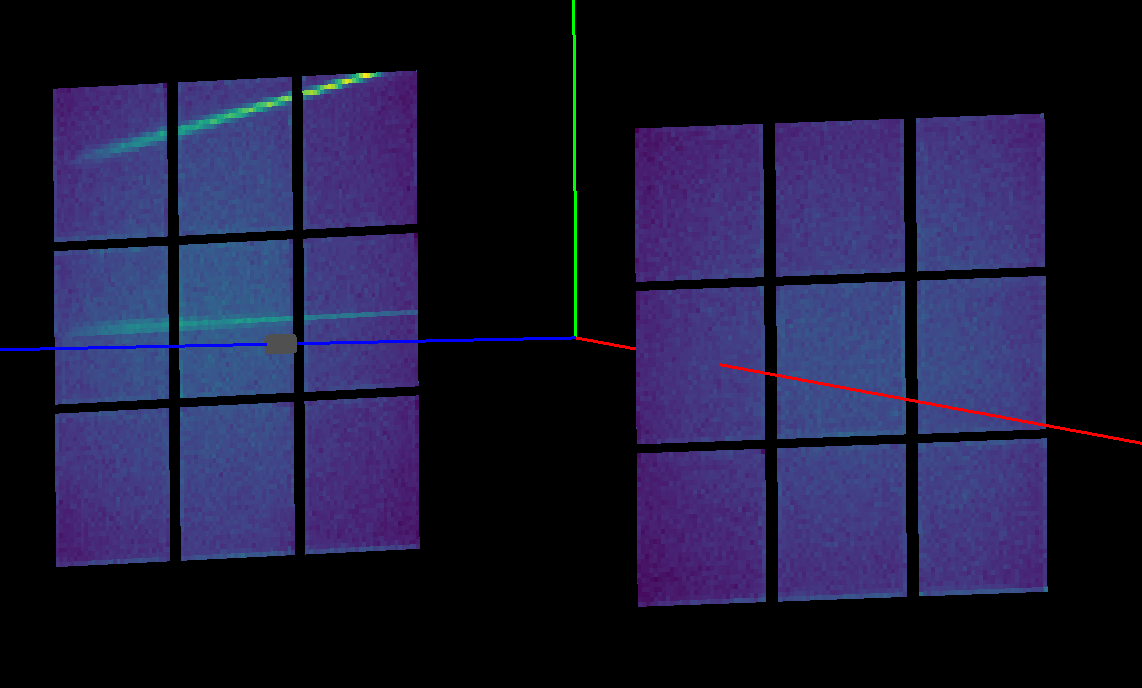

Here, the origin of the image is at the sample position, the green axis is vertical and the blue axis points paralle to the neutron beam. The instrument has two square detectors on opposite sides of the beam. Each detector is formed from 9 modules aligned in a 3x3 grid and each module has 32x32 pixels in it (32x32x9x2 = 18432).

The colour scale shows the total counts in each pixel. (Note that two gaps in the detector shielding led to the bright lines visible in the left-hand side detector!)

Now that we have a workspace holding our data, there are many mantid algorithms available that we can operate on it with. One of the first things we might want to do is convert the X-units from TOF to something more familiar, like d-spacing...

We can do this with a mantid algorithm called `ConvertUnits`:

In [ ]:
ConvertUnits(InputWorkspace='silicon',
            OutputWorkspace='silicon',
            Target = 'dSpacing')

(Note: since I gave the output workspace the same name as the input, I have overwritten the original)

If I look at the properties of the workspace, I now see the units are in d-spacing.

Now I might want to inspect the histograms in individual pixels. `Mantid Workbench` has several very useful visualisation tools. But in this notebook, another way to do it is using matplotlib. We'll define a short python function to make this easy to do.  

In [ ]:
def plotSpectrum(idList,workspaceName):

    #First we need to define a handle, here just called ws, pointing at the workspace.
    ws = mtd[workspaceName]
    #via this handle, we now have access to a large number of methods that can allow us to access the content of the workspace

    
    #now we create a figure and a set of axes
    fig, ax = plt.subplots()
    for id in idList:
        xHist = ws.readX(id)
        x = 0.5*(xHist[:-1]+xHist[1:])
        y = ws.readY(id)
        ax.plot(x,y,label=f'spectrum {id}')

    ax.set_label('Spectra')
    ax.set_xlabel('d-Spacing')
    ax.set_ylabel('normalised Intensity')
    ax.legend()

You might noticed, I set this up to iterate through a list of input spectra ID's. This lets me examine more than one spectra plotted together. I have 18432 spectra available. Here is what the first and last spectra look like: 

In [ ]:
plotSpectrum([0,18431],'silicon')

This shows a rather unimpressive couple of spectra! The reason is that we're only plotting single pixels, which are very small, so don't have many counts.

**We need to add pixels together!!**

## Diffraction Focussing

The process of combining pixels is referred to as "diffraction focussing". This comes from analogy to focusing a lens: when the pixels are converted to d-spacing, any given Bragg peak always has the same value of d-spacing, so they line up or are "focussed".

On this particular instrument, we have a lot of flexibility on how to combine pixels. I could add all the pixels together into one single spectrum, but I am interested in looking at the angular dependence of the data. Mantid provides an easy way to define ways to group pixels based on the components of the detector via an algorithm called `CreateGroupingWorkspace`:   

In [ ]:
CreateGroupingWorkspace(InputWorkspace='silicon', 
                        GroupDetectorsBy='Column', 
                        OutputWorkspace='SNAPColGp')

Here I've defined groups according to the vertical columns of modules in each detector. This creates 6 pixel groups.

**Note: the group are numbers increase as $2\theta$ decreases**

The next step is to combine these which is done with an algorithm called `DiffractionFocusing`:

In [ ]:
DiffractionFocussing(InputWorkspace='silicon',
                     OutputWorkspace='silicon_column',
                     GroupingWorkspace='SNAPColGp')                     

We how have a new workspace `silicon_column` that has 6 spectra. I want to use my function to plot all 6 of these together: 

In [ ]:
plotSpectrum([0,1,2,3,4,5],'silicon_column')

Now I have the correctly calibrated data, but if I zoom in, I can clearly see that they are horribly undersampled, with only one or two bins in each Bragg peak. This is because I still only have (a random default of) 500 equally-sized bins in my histograms. I want to resample my neutron events with a finer binning. Since the original event data are still contained in my workspace, all I have to do is rebin these.

Mantid has an algorithm `Rebin` to do this. This requires the definition of a minimum d-spacing (0.35 Å), a maximum d-spacing (4.7 Å) and a binning parameter that specifies the nature and number of bins. For time-of-flight, a convenient binning scheme is _logarithmic binning_ This generates data bins that are progressively larger at higher d-spacing to match the Bragg peak resolution and ensures approximately constant number of bins across each peak. With logarithmic binning, the x-value of the $n^{th}$ bin edge is given by:

$x_n = x_{n-1}(1+\Delta x)$

or, equivalently

$x_n = x_0(1+\Delta x)^n$

By convention, if a negative sign is used for the binning parameter in mantid, this indicates logarithmic binning with its absolute value giving $\Delta x$.  

In [ ]:
Rebin(InputWorkspace='silicon_column',
      OutputWorkspace='silicon_column',
      Params='0.3,-0.0008,5.26')

plotSpectrum([0,1,2,3,4,5],'silicon_column')

I can now see that my event data are better sampled. These plots already exhibit some of the properties of TOF detectors. The 2$\theta$ values of the columns decrease from low to high angle and we can see that: 

1. The maximum d-spacing increases towards low angle
2. The minimum d-spacing decreases towards high angle
3. The diffraction resolution (Bragg peak width) increases towards higher values.

But if we zoom in to, say the two peaks at 3.1 Å, we will see that they don't quite line up. Since these peaks correspond to the same Bragg reflection, they should have the same d-spacing. This is due to errors in the default mathematical description of the instrument used when calculating the conversion from TOF to d-spacing. To correct for this, we must apply a calibration. This calibration was already measured, and the calibration values (the "Diffractometer Constants") are stored in the provided file `diffract_consts.h5`. We need to convert our  *unfocussed* back to time-of-flight, apply the calibration and then convert to d-spacing again. Now, with the calibration applied, we can diffraction focus the data again.

In [ ]:
ConvertUnits(InputWorkspace='silicon',
             OutputWorkspace='silicon',
             Target='TOF')

ApplyDiffCal(InstrumentWorkspace='silicon', 
             CalibrationFile=f"{dataPath}/diffract_consts.h5")

ConvertUnits(InputWorkspace='silicon',
             OutputWorkspace='silicon',
             Target='dSpacing')

Rebin(InputWorkspace='silicon',
      OutputWorkspace='silicon',
      Params='0.35,-0.0008,4.7')

DiffractionFocussing(InputWorkspace='silicon',
                     OutputWorkspace='silicon_column',
                     GroupingWorkspace='SNAPColGp')

plotSpectrum([0,1,2,3,4,5],'silicon_column')

In [ ]:
plotSpectrum([0,1,2,3,4,5],'silicon_column')

Once I'm sure that I'm happy with my binning, I can finally remove my event data, and only retain the histograms. This can be an important step because the event data can consume a very large amount of memory and this quickly becomes a problem. To do this I can repeat the rebin operation, but now add an additional parameter `PreserveEvents` and set this to be `False`: 

In [ ]:
Rebin(InputWorkspace='silicon_column',
      OutputWorkspace='silicon_column',
      Params='0.30,-0.0008,5.26',
      PreserveEvents=False)

It's important to be aware of what we've done. With the events deleted, any further changes in the histogram will be irreversible! On the plus side, our workspace has reduced in size from about 121 Mb to only 21 Mb (this makes a big difference if you have many datasets).

## Normalising the data

At this point, our data are almost ready to use, but we still need to normalise them for the wavelength response of the instrument. We will do this using our vanadium-niobium data. But to simplify our lives, we can gather all of the operations applied to our silicon data and just repeat them. Mantid does this conveniently as every workspace saves its own history. We can copy that history and use it to create a python script. I've done this below and then iterated through both my vanadium data and my empty data as I'll need both. Notice also, I added a step at the end to delete the original input data. This is again to save using too much memory. 

In [ ]:
dataFiles = ['vanadium-niobium','empty']

for dataFile in dataFiles:
    dataSet = f"{dataPath}/{dataFile}.nxs"
    print(f"full path to data set is: {dataSet}")
    print(f"will create workspace called: {dataFile}")
    
    LoadNexus(Filename=dataSet, OutputWorkspace=dataFile)
    ConvertUnits(InputWorkspace=dataFile, OutputWorkspace=dataFile, Target='dSpacing')
    CreateGroupingWorkspace(InputWorkspace=dataFile, GroupDetectorsBy='Column', OutputWorkspace='SNAPColGp')
    ApplyDiffCal(InstrumentWorkspace=dataFile, CalibrationFile=f"{dataPath}/diffract_consts.h5")
    DiffractionFocussing(InputWorkspace=dataFile, OutputWorkspace=f'{dataFile}_column', GroupingWorkspace='SNAPColGp')
    Rebin(InputWorkspace=f'{dataFile}_column', OutputWorkspace=f'{dataFile}_column', Params='0.30,-0.0008,5.26', PreserveEvents=False)
    DeleteWorkspace(Workspace=dataFile)

In [ ]:
plotSpectrum([0,1,2,3,4,5],'vanadium-niobium_column')

In [ ]:
plotSpectrum([0,1,2,3,4,5],'empty_column')

The normalisation correction we need is captured in the vanadium-niobium scattering so we want to remove any other "background" contribution to that measurement. This is why we collected the "empty" instrument dataset, which should be identical to the vanadium-niobium measurement (e.g. same detector positions and same front end settings) only without the V-Nb. The vanadium-niobium signal we need is obtained by subtracting this empty:

In [ ]:
Minus(LHSWorkspace='vanadium-niobium_column',
      RHSWorkspace='empty_column',
      OutputWorkspace='norm_column')

plotSpectrum([0,1,2,3,4,5],'norm_column')

This gives me the raw data, but I want to do one further processing step, which is to smooth the data. I know that the normalisation correction is slowly varying in d-spacing, and smoothing will avoid adding unnecessary noise to my data. Again, I summon a mantid algorithm. It might be necessary to experiment to find the correct smoothing parameter `NPoints`. 

In [ ]:
SmoothData(InputWorkspace='norm_column',
           OutputWorkspace='norm_column_smooth',
           NPoints = 50)
plotSpectrum([0,1,2,3,4,5],'norm_column_smooth')

## Final reduced data

Now I can apply this normalisation to obtain my reduced data. I will do this with a simple division

In [ ]:
Divide(LHSWorkspace='silicon_column',
       RHSWorkspace='norm_column_smooth',
       OutputWorkspace='silicon_column_final')
plotSpectrum([0,1,2,3,4,5],'silicon_column_final')

Ugh! Why do my data look so bad!? 

This is because at the edge of each individual spectrum, the denominator `norm_column_smooth` becomes very small and the result of dividing becomes ill conditioned (and then NAN where the denominator is exactly zero). Since the d-spacing range is angle dependent, this happens at a different d-spacing for each spectrum. What I really need is custom binning parameters for each spectrum. These can be calculated for each spectrum and are tablulated here: 

|spectrum | average 2$\theta$ (deg) | d$_{min}$ (Å)| d$_{max}$ (Å)| d$_{bin}$ (Å)|
|---------|-------------------------|--------------|--------------|--------------|
|0| 150 |0.35 |2.18 |-0.0008 |
|1| 120 |0.35 |2.41 |-0.0010 |
|2| 110 |0.35 |2.81 |-0.0011 |
|3| 90  |0.35 |2.89 |-0.0013 |
|4| 60  |0.42 |3.69 |-0.0016 |
|5| 50  |0.60 |4.70 |-0.0020 |

TODO: get latest SNAPRed numbers

Mantid has an algorithm `RebinRagged` that can be used to allow each spectrum to have its own binning parameters. Which are provided as a list:

In [ ]:
RebinRagged(InputWorkspace='silicon_column_final',
            OutputWorkspace='silicon_column_final',
            XMin = [0.30,0.33,0.37,0.39,0.45,0.55],
            XMax = [2.22,2.48,2.86,3.05,3.86,5.26],
            Delta = [-0.0008,-0.0008,-0.009,-0.009,-0.001,0.0012])

In [ ]:
plotSpectrum([0,1,2,3,4,5],'silicon_column_final')

Congratulations! Now that your diffraction data are correctly calibrated, normalised and focussed, they are ready to export to a Rietveld package for analysis!